## Manually Label Project Metaphors

Randomly select projects and extract potential metaphors. Manually label whether the presented text fragment contains a metaphorical cancer-related phrase. Focus given to the underlined keyword token.

In [1]:
import os.path as op

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sklearn.metrics import precision_score, recall_score

import re

In [2]:
DATA_PROCESSED = '../data/processed'

UNDERLINE = '\033[4m'
END = '\033[0m'

### Load Projects and Labeled Keywords

In [6]:
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'combined_projects.csv'))

labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv'))

print(f'Total Projects DF: {all_projects.shape}')
print(f'Total Labeled Keywords DF: {labeled.shape}')
print(f'Total Unique Projects Labeled: {labeled.project_id.nunique()}')

Total Projects DF: (2041, 48)
Total Labeled Keywords DF: (1536, 7)
Total Unique Projects Labeled: 806


### Confidence levels

In [7]:
ixs = all_projects.loc[all_projects['source'] == 'gofundme', 'id'].values
filt = labeled.loc[labeled['project_id'].isin(ixs), 'metaphorical'].dropna()
p_hat = filt.mean()
n = len(filt)
del ixs, filt

z005 = 2.575829

print(f'Sample proportion of metaphorical keywords:\t {p_hat*100:.2f}%')
print(f'99% CI:\t ({(p_hat - z005 * np.sqrt(p_hat * (1-p_hat) / n)) * 100:.2f}%, {(p_hat + z005 * np.sqrt(p_hat * (1-p_hat) / n)) * 100:.2f}%)')
print(f'For {p_hat*100:.2f}% +- 1%:\t n > {int(z005**2 * p_hat * (1-p_hat) / 0.01**2):,}')
print(f'For {p_hat*100:.2f}% +- 0.5%:\t n > {int(z005**2 * p_hat * (1-p_hat) / 0.005**2):,}')

Sample proportion of metaphorical keywords:	 88.84%
99% CI:	 (85.64%, 92.03%)
For 88.84% +- 1%:	 n > 6,579
For 88.84% +- 0.5%:	 n > 26,318


In [8]:
# these are ordered lists - since we search in order the lemma comes last (so not to catch non-lemma'd words)

BATTLE_WORDS = ['fights', 'fighting', 'fight', 'fought', 'battles', 'battled', 'battling', 'battle', 'war', 'beating', 'beats', 'beaten', 'beat', 'enemy', 'brutal', 'defeat', 'winning', 'win']

JOURNEY_WORDS = ['path', 'journey', 'destination']

window = 80

# Manually Label Metaphors

In [9]:
def find_keywords(text, source, source_type):
    '''
    Search `text` for all instances of keywords in `source`.
    '''
    if not isinstance(text, float):
        for kw in source:
            exp = r'\W(' + kw + ')\W'
            for kw_match in re.finditer(exp, text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(project.text), kw_match.end() + window)

                prompt = text[start:kw_match.start()+1] + UNDERLINE + text[kw_match.start()+1:kw_match.end()-1] + END + text[kw_match.end()-1:end]

                yield prompt, {'fragment': text[start:end], 
                               'char_location': float(kw_match.start()),
                               'kw_start': int(kw_match.start()) - int(start) + 1,
                               'type': source_type, 
                               'keyword': kw}
            
def is_metaphorical():
    res = input('Is this a cancer related metaphor? ')
    return res == 'y'

def exists_with_keyword(source, ix, char_location):
    '''
    Does the given project, with ID `ix`, exist in `source` with a keyword at `char_location`?
    '''
    return char_location in source.loc[source['project_id'] == ix, 'char_location'].values
    
def exists_without_keywords(source, ix):
    '''
    Does the given project, with ID `ix`, exist in `source` as a null (meaning, it has been seen previously
    and labeled as having no keywords)?
    '''
    locs = source.loc[source['project_id'] == ix, 'char_location']
    return len(locs) == 1 and sum(locs.isnull()) == 1

def max_unlabeled():
    return len(all_projects.loc[~all_projects['id'].isin(labeled['project_id'])])

In [10]:
c = int(input('Instances to label: '))

tp, fp, nan = 0, 0, 0
        
for project in all_projects.sample(frac=1).itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    keyword_found = False
    
    for source, key in [(BATTLE_WORDS, 'battle'), (JOURNEY_WORDS, 'journey')]:
        for prompt, result in find_keywords(project.text, source, key):
            
            if exists_with_keyword(labeled, project.id, result['char_location']):
                continue
            
            if exists_without_keywords(labeled, project.id):
                labeled = labeled.loc[labeled['project_id'] != project.id]
                
            c -= 1
            keyword_found = True
            print(prompt)
            result['project_id'] = project.id
            if is_metaphorical():
                result['metaphorical'] = True
                labeled = labeled.append(result, ignore_index=True)                
                tp += 1
            else:
                result['metaphorical'] = False
                labeled = labeled.append(result, ignore_index=True)
                fp += 1
                
    # if no metaphor existed and this isn't already known
    if not keyword_found and not exists_without_keywords(labeled, project.id):
        result = {'project_id': project.id,
                    'fragment': np.nan, 
                    'char_location': np.nan,
                    'kw_start': np.nan,
                    'type': 'none',
                    'metaphorical': np.nan,
                    'keyword': np.nan}
        
        labeled = labeled.append(result, ignore_index=True)  
        nan += 1
        print('No metaphors found')
    
    if c <= 0:
        break

print(f'True Positives: {tp} - False Positives: {fp} - Non-existent: {nan}')

Instances to label: 5

PROJECT Cancer fighter
 survivor. She is a mother of 2 children. She is a person who never gives up and fights even when others give up. She was diagnosed with breast cancer in 2003. She had 
Is this a cancer related metaphor? 

PROJECT Katie vs. Cancer

PROJECT Jakes Fight Against Cancer
f you would like to help fund medical costs and expenses for Jakes long-standing fight against cancer. Any amount that you would like to donate would be greatly apprec
Is this a cancer related metaphor? y

PROJECT I Believe God: a 40-day healing journey (a daily devotional)
od Friday, because our desire has been that the Lord would use for good what the enemy meant for destruction.  The plan has been to give 10% of net proceeds to YoungLi
Is this a cancer related metaphor? 
This project is the result. The book is called, "I Believe God: a 40-day healing journey." In it, I share the life-changing truths we've experienced, but much more impor
Is this a cancer related metaphor? 
ge

In [11]:
print(labeled.duplicated().sum())
labeled = labeled.drop_duplicates()

1


Total metaphor examples: 894


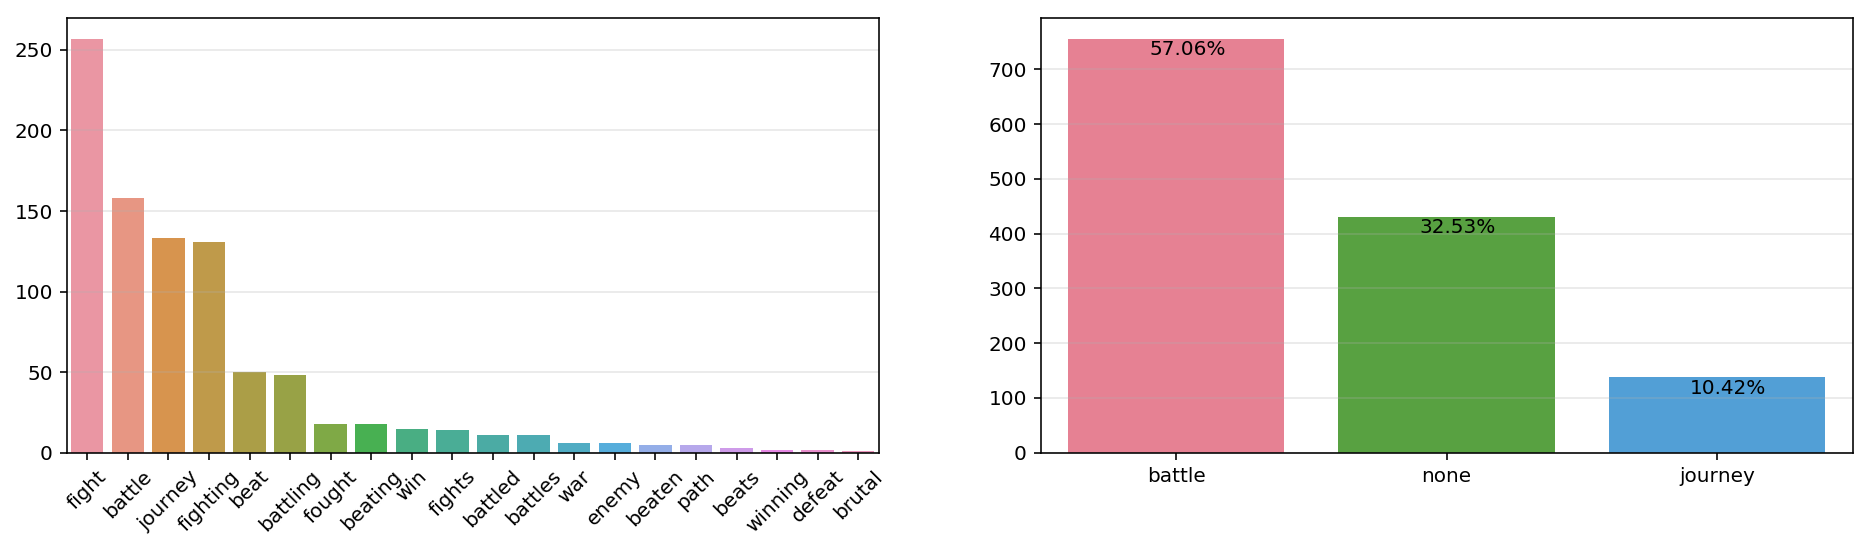

In [12]:
print(f'Total metaphor examples: {len(labeled.loc[labeled["metaphorical"] == True])}')

plt.subplots(1, 2, figsize=(16,4))

plt.subplot(1,2,1)
vc = labeled.loc[labeled['metaphorical'] == True, 'keyword'].value_counts();
sns.barplot(vc.index, vc.values)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1,2,2)
vc = labeled.loc[labeled['metaphorical'] != False, 'type'].value_counts()
g = sns.barplot(vc.index, vc.values, palette='husl')
plt.grid(axis='y', alpha=0.3)

s = sum(vc.values)
for p in g.patches:
    h = p.get_height()
    plt.text(p.get_x() + 0.3, h - 80, f'{h/s*100:.2f}%')

In [13]:
labeled.to_csv(op.join(DATA_PROCESSED, 'labeled.csv'), index=False)

### TODO

o is the campaign about raising money for research, product, book, diets, etc. journey as raising money

o cancer fighting the patient, not the other way around - bring in POS to figure out if cancer is a subject or object, "cancer can’t beat us", "battle scars"

o situational model, looking at prosidy in speech

# Auto-Detection

First attempt is with simple regular expressions.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
labeled_kw_exists = labeled.dropna()
train_ixs, test_ixs = train_test_split(np.arange(len(labeled_kw_exists)), train_size=0.8, stratify=labeled_kw_exists['metaphorical'])

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
def related_to_cancer(text):
    '''
    Does the given text contain cancer-related keywords?
    '''
    return 'cancer' in text or 'leukemia' in text or 'melanoma' in text or 'lymphoma' in text

def regex_find_metaphors(text):
    if not isinstance(text, float):
            
        if related_to_cancer(text.lower()):
                        
            for kw_match in re.finditer(r'\W(fight|fights|fighting|fought)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                next_ = text[kw_match.start():kw_match.end()+50].split()
#                 if text[kw_match.end()-1:kw_match.end()] in ['-', '/', '_']

                if len(next_) > 1 and re.match(r'(pain|depression|club|fear|anxiety|stress)', next_[1]):
                    continue
                
                yield {'fragment': text[start:end],
                       'char_location': kw_match.start(), 
                       'type': 'battle', 
                       'keyword': kw_match[1]}
                
            for kw_match in re.finditer(r'\W(battle|battles|battling|battled|beat|beats|beaten|beating|brutal)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                
                if kw_match.start() > 10 and text[kw_match.start()-10:kw_match.start()].split()[-1] in ['in', 'into']:
                    continue
                
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'battle', 
                        'keyword': kw_match[1]}
                
            if 'character' not in text.lower() and 'hero' not in text.lower():
                for kw_match in re.finditer(r'\W(enemy)\W', text.lower()):
                    start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                    yield {'fragment': text[start:end],
                           'char_location': kw_match.start(), 
                           'type': 'battle', 
                           'keyword': 'enemy'}
                    
            for kw_match in re.finditer(r'\W(path|destination)\W', text.lower()):
                start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
                yield {'fragment': text[start:end],
                        'char_location': kw_match.start(), 
                        'type': 'journey', 
                        'keyword': kw_match[1]}
                
        for kw_match in re.finditer(r'\W(journey)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() + window)
            prev_ = text[kw_match.start()-50:kw_match.end()].split()
            next_ = text[kw_match.start():kw_match.end()+50].split()

            if len(prev_) > 1 and ('will' in prev_):
                continue
                
            if len(next_) > 1 and (next_[1] in ['from', 'will', 'across'] or 'time' in next_):
                continue

            surround = text[kw_match.start()-50:kw_match.end()+50]
            if 'theatrical' in surround:
                continue

            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'journey', 
                   'keyword': 'journey'}
        
        for kw_match in re.finditer(r'\W(war (with|against|on) cancer|cancer war)\W', text.lower()):
            start, end = max(0, kw_match.start() - window), min(len(text), kw_match.end() - 8 + window)
            yield {'fragment': text[start:end],
                   'char_location': kw_match.start(), 
                   'type': 'battle', 
                   'keyword': 'war'}
        

In [18]:
regex_predicted_labeled = labeled_kw_exists.copy().iloc[test_ixs].reset_index(drop=True)
regex_predicted_labeled['predicted'] = False

In [19]:
preds = []

missing = []

for project in regex_predicted_labeled.itertuples():
    try:
        for metaphor in regex_find_metaphors(all_projects.loc[all_projects['id'] == project.project_id, 'text'].values[0]):
            if metaphor['char_location'] == project.char_location:
                preds.append(project.Index)
    except IndexError:
        print(f'No text with {project.project_id}')
        missing.append(project.project_id)

In [20]:
regex_predicted_labeled.iloc[preds, -1] = True

In the following charts, we hope to have all blue and no orange, or more realistically, large blue bars and small orange bars for each keyword.

The charts are broken into two: one for true metaphorical usage of the keyword, one for non-metaphorical usage of the keyword. Note that the x-axes are different because not every keyword in one of those groups in is the other.

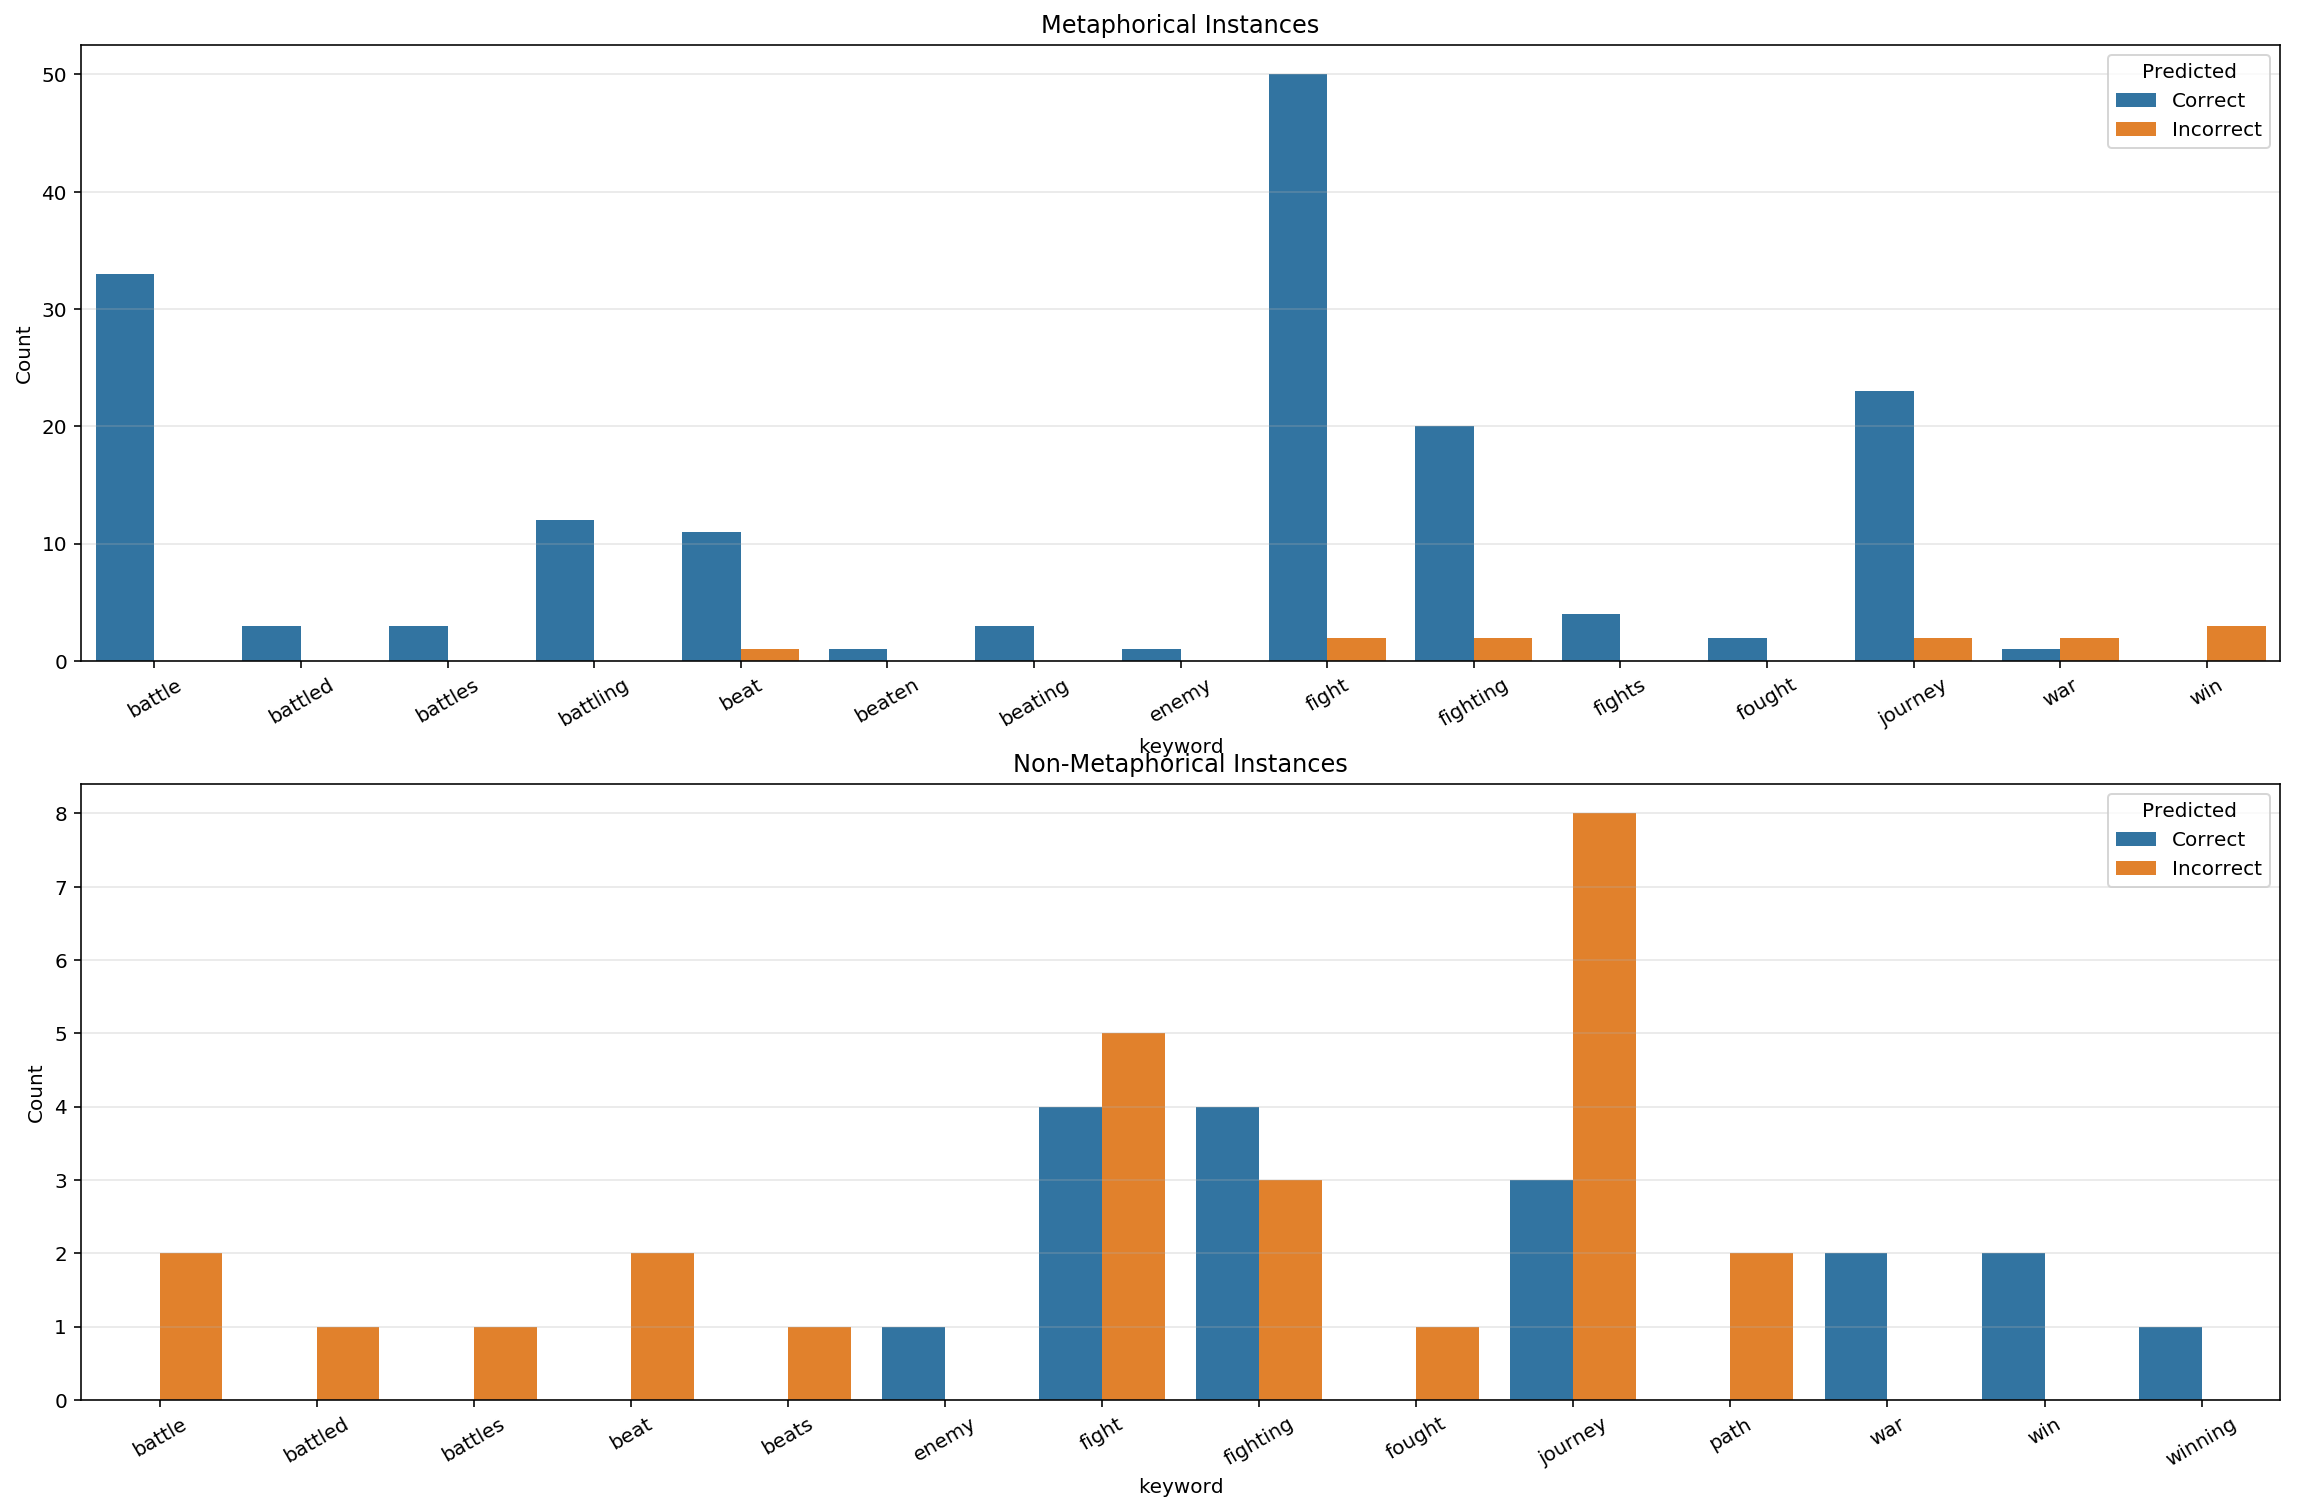

In [21]:
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(211)

g = regex_predicted_labeled.loc[regex_predicted_labeled['metaphorical'] == True].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': s, 'Incorrect': c - s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.subplot(212)

g = regex_predicted_labeled.loc[regex_predicted_labeled['metaphorical'] == False].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': c - s, 'Incorrect': s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Non-Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

# Neural Net Detection

In [22]:
from tqdm import tqdm_notebook as tqdm

from allennlp.commands.elmo import ElmoEmbedder

from nltk.tokenize import RegexpTokenizer

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/allennlp/commands/find_learning_rate.py:42: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/alex/anaconda3/envs/nlp/lib/py

In [23]:
elmo = ElmoEmbedder()
tokenizer = RegexpTokenizer(r'\w+')

In [24]:
def pad(s, kw_start, lim=20):
    '''
    Limit a fragment to `lim` tokens. If less than, pad with empty strings.
    '''
    
    prior = tokenizer.tokenize(s[:kw_start])
    post = tokenizer.tokenize(s[kw_start:])
    
    if len(prior) < lim/2:
        while len(prior) < lim/2:
            prior.insert(0, '')
    else:
        prior = prior[len(prior) - round(lim/2):]
        
    if len(post) < lim/2:
        while len(post) < lim/2:
            post.append('')
    else:
        post = post[:round(lim/2)]
        
    prior.extend(post)
    return prior

In [25]:
neural_predicted_labeled = labeled_kw_exists.copy().iloc[test_ixs].reset_index(drop=True)
neural_predicted_labeled['predicted'] = False

In [28]:
tokens = 20

fragments = [pad(fragment.fragment, int(fragment.kw_start), tokens) for fragment in labeled_kw_exists[['fragment', 'kw_start']].itertuples()]

In [29]:
embds = elmo.embed_sentences(fragments)
embedded_fragments = np.array([embd[2] for embd in tqdm(embds)])

In [30]:
embedded_fragments.shape

(1108, 20, 1024)

In [31]:
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras import optimizers

from sklearn.utils.class_weight import compute_class_weight

from sklearn import metrics

Using TensorFlow backend.


In [32]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    return 2*((p*r)/(p+r+K.epsilon()))

In [33]:
def build_model(input_tokens):

    inputs = Input(shape=(20, 1024), name="input")

    x = Bidirectional(GRU(20, return_sequences=True, name="gru"))(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(20, name='gru2'))(x)

    x = Dropout(0.1)(x)
    x = Dense(20, activation='relu', name="dense")(x)
        
    predictions = Dense(2, activation='softmax', name="out")(x)
    _model = Model(inputs=inputs, outputs=predictions)

    _model.compile(optimizer=optimizers.Adam(lr=0.5*1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=[f1])
    
    return _model

In [36]:
model = build_model(tokens)
        
model.fit(embedded_fragments[train_ixs], labeled_kw_exists.iloc[train_ixs]['metaphorical'], epochs=20, class_weight={0: 50.0, 1: 1.0}, verbose=1)

Epoch 1/20
886/886 [==============================] - 5s 6ms/step - loss: 3.5191 - f1: 0.8907
Epoch 2/20
886/886 [==============================] - 2s 3ms/step - loss: 2.7124 - f1: 0.8912
Epoch 3/20
886/886 [==============================] - 2s 2ms/step - loss: 2.5469 - f1: 0.8910
Epoch 4/20
886/886 [==============================] - 2s 3ms/step - loss: 2.2910 - f1: 0.8920
Epoch 5/20
886/886 [==============================] - 3s 3ms/step - loss: 1.9202 - f1: 0.8921
Epoch 6/20
886/886 [==============================] - 3s 3ms/step - loss: 1.5530 - f1: 0.8916
Epoch 7/20
886/886 [==============================] - 2s 3ms/step - loss: 1.1499 - f1: 0.8914
Epoch 8/20
886/886 [==============================] - 2s 3ms/step - loss: 0.8713 - f1: 0.8917
Epoch 9/20
886/886 [==============================] - 2s 2ms/step - loss: 0.5638 - f1: 0.8912
Epoch 10/20
886/886 [==============================] - 2s 2ms/step - loss: 0.3590 - f1: 0.8912
Epoch 11/20
886/886 [==============================] - 2s 2

NameError: name 'X_test' is not defined

## Results

In [39]:
neural_predicted_labeled = labeled_kw_exists.copy().iloc[test_ixs].reset_index(drop=True)
neural_predicted_labeled['predicted'] = model.predict(embedded_fragments[test_ixs]).argmax(axis=1).astype(bool)

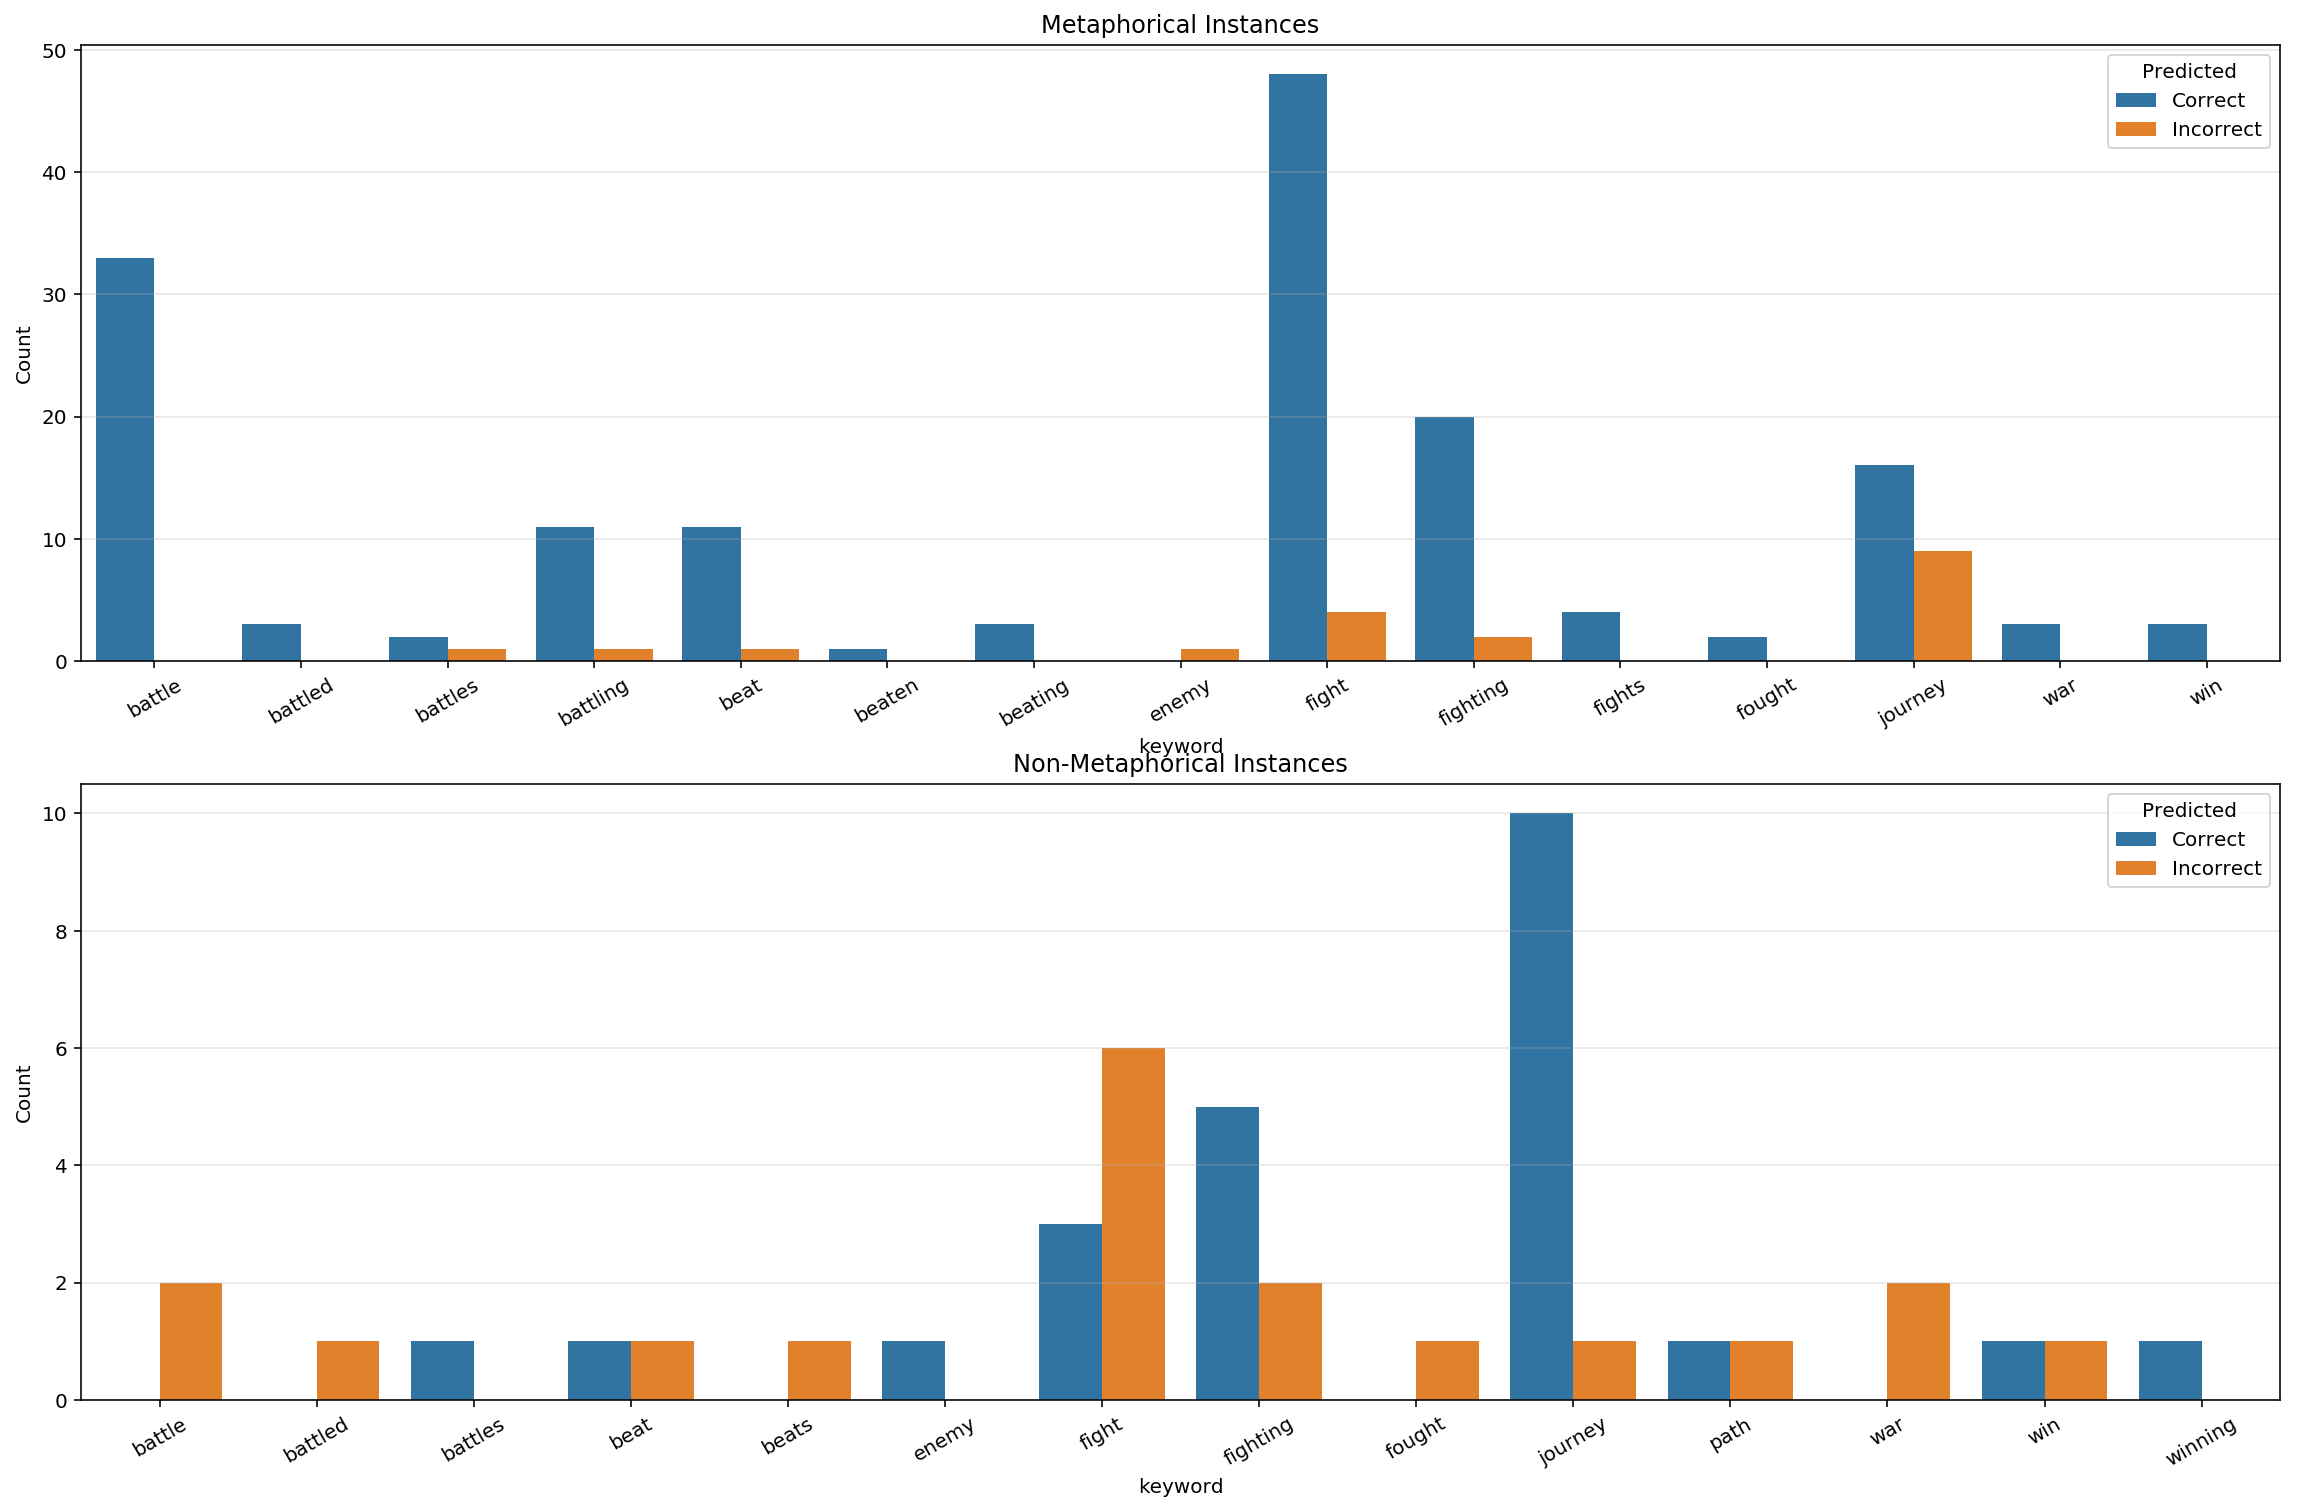

In [40]:
plt.subplots(figsize=(16,10))
plt.tight_layout()

plt.subplot(211)

g = neural_predicted_labeled.loc[neural_predicted_labeled['metaphorical'] == True].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': s, 'Incorrect': c - s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

plt.subplot(212)

g = neural_predicted_labeled.loc[neural_predicted_labeled['metaphorical'] == False].groupby('keyword').agg({'predicted': ['sum', 'count']})
s, c = g['predicted']['sum'], g['predicted']['count']

coll = pd.concat({'Correct': c - s, 'Incorrect': s}, axis=0).reset_index()

coll.rename(columns={'level_0': 'Predicted', 0: 'Count'}, inplace=True)

plt.grid(alpha=0.3, axis='y')
plt.title('Non-Metaphorical Instances')
g = sns.barplot(y='Count', x='keyword', hue='Predicted', data=coll)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

### Model Comparison

In [41]:
pd.crosstab(regex_predicted_labeled['metaphorical'], regex_predicted_labeled['predicted'], rownames=['Truth'], colnames=['Predicted'], margins=True)


Predicted,False,True,All
Truth,,,
False,17,26,43
True,12,167,179
All,29,193,222


In [42]:
pd.crosstab(neural_predicted_labeled['metaphorical'], neural_predicted_labeled['predicted'], rownames=['Truth'], colnames=['Predicted'], margins=True)


Predicted,False,True,All
Truth,,,
False,24,19,43
True,19,160,179
All,43,179,222


In [46]:
print('Regex Model Cohen\'s Kappa:')
print(metrics.cohen_kappa_score(regex_predicted_labeled['metaphorical'].astype(bool), regex_predicted_labeled['predicted']))
print('Neural Model Cohen\'s Kappa:')
print(metrics.cohen_kappa_score(neural_predicted_labeled['metaphorical'].astype(bool), neural_predicted_labeled['predicted']))
print('Inter-model Cohen\'s Kappa:')
print(metrics.cohen_kappa_score(regex_predicted_labeled['metaphorical'].astype(bool), neural_predicted_labeled['predicted']))

Regex Model Cohen's Kappa:
0.3746478873239436
Neural Model Cohen's Kappa:
0.45199428348707293
Inter-model Cohen's Kappa:
0.45199428348707293


### Predict on unseen data

In [ ]:
def embed_fragment(fragment, start, tokens):
    tokens = pad(fragment, start, tokens)
    return elmo.embed_sentence(tokens)[2]

In [ ]:
c = int(input(f'N (max: {int(max_unlabeled()):,}): '))

tp, fp, nan = 0, 0, 0
        
for project in all_projects.sample(frac=1).itertuples():
    
    print()
    print(f'PROJECT {project.name}')
    
    keyword_found = False
    
    for source, key in [(BATTLE_WORDS, 'battle'), (JOURNEY_WORDS, 'journey')]:
        for prompt, result in find_keywords(project.text, source, key):
            
            if exists_with_keyword(labeled, project.id, result['char_location']):
                continue
            
            if exists_without_keywords(labeled, project.id):
                labeled = labeled.loc[labeled['project_id'] != project.id]
            
            keyword_found = True
            print(prompt)
            result['project_id'] = project.id
            
            embedding = embed_fragment(result['fragment'], int(result['kw_start']), tokens)
            prediction = model.predict(np.array([embedding]))
                
            # only present if low confidence
#             if prediction[0].max() < confidence_threshold:
            print(f'Non-Metaphorical: {prediction[0][0]:.3f}\t Metaphorical: {prediction[0][1]:.3f}')
            
            if is_metaphorical():
                result['metaphorical'] = True
                labeled = labeled.append(result, ignore_index=True)                
                tp += 1
            else:
                result['metaphorical'] = False
                labeled = labeled.append(result, ignore_index=True)
                fp += 1
                
    if keyword_found:
        c -= 1
        
    # if no metaphor existed and this isn't already known
    if not keyword_found and not exists_without_keywords(labeled, project.id):
        result = {'project_id': project.id,
                    'fragment': np.nan, 
                    'char_location': np.nan,
                    'kw_start': np.nan,
                    'type': 'none',
                    'metaphorical': np.nan,
                    'keyword': np.nan}
        
        labeled = labeled.append(result, ignore_index=True)  
        nan += 1
        print('No metaphors found')
    
    if c <= 0:
        break

print(f'True Positives: {tp} - False Positives: {fp} - Non-existent: {nan}')